**3/31/21**

The purpose of this notebook is to dig into the areas where the Hybrid_Sample-Matched databases outperform the 16S_Sample-Matched databases.

In [1]:
from elliot_utils import *
from scipy import stats

In [2]:
figPath = Path.cwd().joinpath('figures/analyzing_hybrid/')
analysisPath = Path.cwd().joinpath('analysis_files/analyzing_hybrid/')

In [3]:
tailoredResults = getOrderedFiles(Path.cwd().joinpath(TAILORED_RESULTS), '.tsv')
individualResults = getOrderedFiles(Path.cwd().joinpath(SINGLE_RESULTS), '.tsv')
hybridResults = getOrderedFiles(Path.cwd().joinpath(HYBRID_RESULTS), '.tsv')

In [4]:
tAllowedHumanPeps = getFilteredPeptides(tailoredResults, 'human')
iAllowedHumanPeps = getFilteredPeptides(individualResults, 'human')
hAllowedHumanPeps = getFilteredPeptides(hybridResults, 'human')
tAllowedBacteriaPeps = getFilteredPeptides(tailoredResults, 'bacteria')
iAllowedBacteriaPeps = getFilteredPeptides(individualResults, 'bacteria')
hAllowedBacteriaPeps = getFilteredPeptides(hybridResults, 'bacteria')

In [5]:
# Returns a list with the number of statistically significant PSMs in the samples of the specified type.
# Can specify a set of allowed peptides to filter
def countSpectra(resultsList, lookFor, allowedPeps):
    counts = []
    for res in resultsList:
        with res.open(mode='r') as infile:
            reader = csv.reader(infile, delimiter='\t')
            count = 0
            for row in reader:
                protType = determineIDType(row)
                if protType == 'first':
                    continue
                if not isSignificant(row):
                    break
                if protType == lookFor and row[PEPTIDE] in allowedPeps:
                    count += 1
        counts.append(count)
    return counts

In [6]:
tHumanCount = countSpectra(tailoredResults, 'human', allowedPeps=tAllowedHumanPeps)
hHumanCount = countSpectra(hybridResults, 'human', allowedPeps=hAllowedHumanPeps)
iHumanCount = countSpectra(individualResults, 'human', allowedPeps=iAllowedHumanPeps)
tBacteriaCount = countSpectra(tailoredResults, 'bacteria', allowedPeps=tAllowedBacteriaPeps)
hBacteriaCount = countSpectra(hybridResults, 'bacteria', allowedPeps=hAllowedBacteriaPeps)
iBacteriaCount = countSpectra(individualResults, 'bacteria', allowedPeps=iAllowedBacteriaPeps)

In [7]:
humanProportion = []
bacteriaProportion = []
dataLabels = []
for i in range(len(tHumanCount)):
    humanProportion.append(hHumanCount[i] / tHumanCount[i])
    bacteriaProportion.append(hBacteriaCount[i] / tBacteriaCount[i])
    dataLabels.append('Public_Tailored')
    humanProportion.append(hHumanCount[i] / iHumanCount[i])
    bacteriaProportion.append(hBacteriaCount[i]/ iBacteriaCount[i])
    dataLabels.append('Shotgun_Single')

In [8]:
proteinDataDir = Path('C:/Users/emlee/Documents/MSGFp/Sequences/Bacteria/AllNCBI_12-19/')

In [9]:
# Get the number of genomes I have for each organism, collapsing all Gardnerellas into Gardnerella vaginalis
genomeCounts = {'Gardnerella vaginalis':0} #key=species name, value=number of genomes
for folder in proteinDataDir.iterdir():
    speciesName = folder.name.replace('_', ' ')
    genomeCount = 0
    for f in proteinDataDir.joinpath(f'{folder.name}/').iterdir():
        if f.suffix == '.fasta':
            genomeCount += 1
    if speciesName.find('Gardnerella') != -1:
        genomeCounts['Gardnerella vaginalis'] += genomeCount
    else:
        genomeCounts[speciesName] = genomeCount

In [10]:
abundanceDataFile = Path.cwd().joinpath('analysis_files/hybrid_vs_tailored/taxa_abundance.csv')
abundanceData = pd.read_csv(abundanceDataFile)

In [56]:
# Verify I haven't misspelled any species names by printing missed species
# Species printed should have no available genomes
#for species in abundanceData['taxa']:
#    if not species in genomeCounts.keys():
#        print(species)
# Confirmed. Don't need to run this code again

In [185]:
# Calculate depth for each sample
sampleDepth = []
for sample in SAMPLE_NAMES:
    sampleData = abundanceData.loc[abundanceData['sample'] == int(sample)]
    vals = []
    for index, row in sampleData.iterrows():
        ra = row['abundance'] / 100
        if row['taxa'] in genomeCounts.keys():
            vals.append(math.log(1 + genomeCounts[row['taxa']]) * ra)
        else:
            vals.append(0)
    sampleDepth.append(sum(vals))

In [186]:
hVsTProportion = []
for i in range(len(hBacteriaCount)):
    hVsTProportion.append(tBacteriaCount[i] / hBacteriaCount[i])

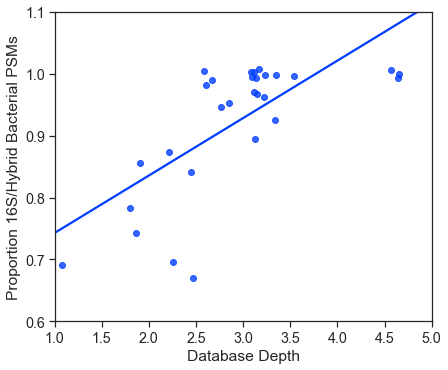

In [187]:
setPlt(size=(6, 5), xlim=(1, 5), ylim=(0.6, 1.1))
proportionVSDepthDF = pd.DataFrame({'Database Depth':sampleDepth, 'Proportion 16S/Hybrid Bacterial PSMs':hVsTProportion})
depthGraph = sns.regplot(x='Database Depth', y='Proportion 16S/Hybrid Bacterial PSMs', data=proportionVSDepthDF, ci=1)
saveFig(depthGraph, figPath.joinpath('depth_correlation.png'))

In [188]:
# Test whether there's a statistically significant association between Sample Depth and Proportion of Tailored:Hybrid bacterial PSMs
stats.spearmanr(hVsTProportion, sampleDepth)

SpearmanrResult(correlation=0.6704433497536945, pvalue=6.907887601184056e-05)

So that's good, I find a statistically significant association between Sample Depth and the relative performance of the 16S_Sample-Matched and Hybrid databases. I also plugged those values into excel to get the equation of the regression line, which gave **y = 0.0904x + 0.6585**. When the proportion = 1, the 16S_Sample-Matched and Hybrid databases have equal performance, so anything below that would mean there's value in using a database that includes metagenomic sequencing. According to that regression line then, we'd expect the proportion to equal 1 when Sample Depth equals 3.778. So, when Sample Depth < 3.778, there's a benefit in including metagenomic sequencing. When Sample Depth > 3.778, the 16S_Sample-Matched database performs fine. From that, we can also determine that we can also determine you would need about 47 genomes for your bugs to cross the point where metagenomic sequencing is no longer necessary.

In [ ]:
# Test some alternate methods of calculating database depth
# First, calculate the number of unique tryptic peptides 

In [11]:
# Takes a deduplicated FASTA file of bacterial proteins
# Returns the number of tryptic peptides with length ≥6 amino acids (Swaney, Wenger, & Coon [2010]) generated by processing all those proteins
def calcTrypticPeptides(fastaFile):
    trypticPeptides = set()
    with open(fastaFile, 'r') as infile:
        rawText = infile.read()
        dataList = rawText.split('\n>')
        dataList[0] = dataList[0][1:]
        del rawText
        for sequence in dataList:
            protein = Protein(sequence)
            seq = protein.sequence
            trypticList = []
            for i in range(len(seq)):
                trypticList.append(seq[i])
                if i + 1 == len(seq):
                    if len(trypticList) > 5:
                        trypticPeptides.add(''.join(trypticList))
                    trypticList = []
                    continue
                if (seq[i] == 'K' or seq[i] == 'R') and seq[i + 1] != 'P':
                    if len(trypticList) > 5:
                        trypticPeptides.add(''.join(trypticList))
                    trypticList = []
    return len(trypticPeptides)

In [50]:
peptideDataDir = Path.cwd().joinpath('../PublicSequences/Combined_AllNCBI_12-21/')

In [14]:
# Get the number of unique tryptic peptides I have for each organism, collapsing all Gardnerellas into G. vaginalis
#trypticCounts = {'Gardnerella vaginalis':0} #key=species name, value=number of tryptic peptides
#for file in peptideDataDir.iterdir():
#    if not file.suffix == '.fasta':
#        continue
#    speciesName = file.name.replace('_', ' ')
#    if speciesName.find('Gardnerella') != -1:
#        trypticCounts['Gardnerella vaginalis'] += calcTrypticPeptides(file)
#    else:
#        trypticCounts[speciesName] = calcTrypticPeptides(file)

In [13]:
trypticCountsFile = analysisPath.joinpath('species_tryptic_peptides.csv')

In [14]:
# It took a while to get the number of tryptic peptides for all species, so I'll write that out to a csv file to make it easier to access
#with trypticCountsFile.open(mode='w', newline='') as outfile:
#    writer = csv.writer(outfile)
#    for s, count in trypticCounts.items():
#        species = s.replace('.fasta', '')
#        writer.writerow([species, str(count)])

In [15]:
trypticCounts = {} #key=species name, value=number of tryptic peptides
with trypticCountsFile.open(mode='r') as infile:
    reader = csv.reader(infile)
    for row in reader:
        species = row[0]
        count = int(row[1])
        if species != '':
            trypticCounts[species] = count

In [35]:
# Calculate the proportion of PSMs for the hybrid versus the 16S_Sample-matched databases
TvsHProportion = []
for i in range(len(hBacteriaCount)):
    TvsHProportion.append(tBacteriaCount[i] / hBacteriaCount[i])

In [77]:
# Calculate sample depth using the untransformed number of tryptic peptides we have for each organism
sampleDepth = []
for sample in SAMPLE_NAMES:
    sampleData = abundanceData.loc[abundanceData['sample'] == int(sample)]
    vals = []
    for index, row in sampleData.iterrows():
        ra = row['abundance'] / 100
        if row['taxa'] in trypticCounts.keys():
            vals.append(trypticCounts[row['taxa']] * ra)
        else:
            vals.append(0)
    sampleDepth.append(sum(vals))

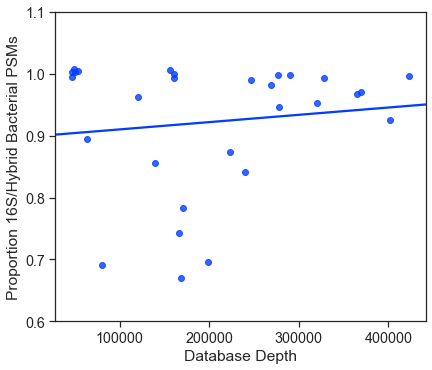

In [78]:
setPlt(size=(6, 5), ylim=(0.6, 1.1))
proportionVSDepthDF = pd.DataFrame({'Database Depth':sampleDepth, 'Proportion 16S/Hybrid Bacterial PSMs':TvsHProportion})
depthGraph = sns.regplot(x='Database Depth', y='Proportion 16S/Hybrid Bacterial PSMs', data=proportionVSDepthDF, ci=1)
saveFig(depthGraph, figPath.joinpath('depth2_correlation.png'))

In [80]:
# Test whether there's a statistically significant association between tryptic peptide Sample Depth and Proportion of Tailored:Hybrid bacterial PSMs
stats.spearmanr(TvsHProportion, sampleDepth)

SpearmanrResult(correlation=-0.2009852216748768, pvalue=0.2958172885690088)

In [45]:
# Calculate sample depth using the natural log of tryptic peptides we have for each organism
sampleDepth = []
for sample in SAMPLE_NAMES:
    sampleData = abundanceData.loc[abundanceData['sample'] == int(sample)]
    vals = []
    for index, row in sampleData.iterrows():
        ra = row['abundance'] / 100
        if row['taxa'] in trypticCounts.keys():
            vals.append(math.log(trypticCounts[row['taxa']]) * ra)
        else:
            vals.append(0)
    sampleDepth.append(sum(vals))

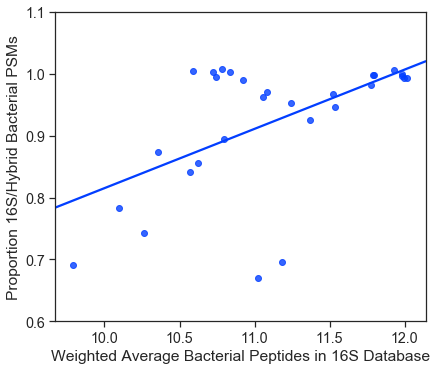

In [47]:
setPlt(size=(6, 5), ylim=(0.6, 1.1))
proportionVSDepthDF = pd.DataFrame({'Weighted Average Bacterial Peptides in 16S Database':sampleDepth, 'Proportion 16S/Hybrid Bacterial PSMs':TvsHProportion, 'BV':BV_STATUS})
depthGraph = sns.regplot(x='Weighted Average Bacterial Peptides in 16S Database', y='Proportion 16S/Hybrid Bacterial PSMs', ci=1, data=proportionVSDepthDF)
saveFig(depthGraph, figPath.joinpath('depth3_correlation.png'))

In [48]:
# Test whether there's a statistically significant association between tryptic peptide Sample Depth and Proportion of Tailored:Hybrid bacterial PSMs
stats.spearmanr(TvsHProportion, sampleDepth)

SpearmanrResult(correlation=0.41527093596059106, pvalue=0.025078553027092974)

In [137]:
# Calculate sample depth using the natural log of tryptic peptides we have for each organism, divided by the number of organisms in each sample
sampleDepth = []
for sample in SAMPLE_NAMES:
    sampleData = abundanceData.loc[abundanceData['sample'] == int(sample)]
    vals = []
    for index, row in sampleData.iterrows():
        ra = row['abundance'] / 100
        if row['taxa'] in trypticCounts.keys():
            vals.append(trypticCounts[row['taxa']] * ra)
        else:
            vals.append(0)
    sampleDepth.append(math.log(sum(vals) / len(vals)))

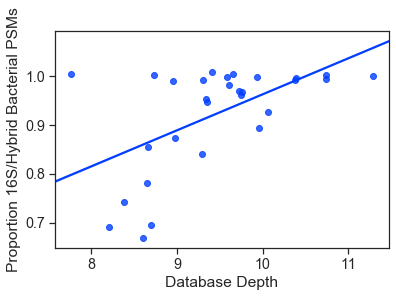

In [138]:
#setPlt(size=(6, 5), ylim=(0.6, 1.1))
proportionVSDepthDF = pd.DataFrame({'Database Depth':sampleDepth, 'Proportion 16S/Hybrid Bacterial PSMs':TvsHProportion, 'BV':BV_STATUS})
depthGraph = sns.regplot(x='Database Depth', y='Proportion 16S/Hybrid Bacterial PSMs', data=proportionVSDepthDF, ci=1)
#saveFig(depthGraph, figPath.joinpath('depth3_correlation.png'))

In [132]:
# Test whether there's a statistically significant association between tryptic peptide Sample Depth and Proportion of Tailored:Hybrid bacterial PSMs
stats.spearmanr(TvsHProportion, sampleDepth)

SpearmanrResult(correlation=0.4679802955665023, pvalue=0.010463871566637343)

In [122]:
# Calculate sample depth using the natural log of tryptic peptides we have for each organism, and dividing by the shannon diversity
sampleDepth = []
for sample in SAMPLE_NAMES:
    sampleData = abundanceData.loc[abundanceData['sample'] == int(sample)]
    vals = []
    shannon = []
    for index, row in sampleData.iterrows():
        ra = row['abundance'] / 100
        if row['taxa'] in trypticCounts.keys():
            vals.append(math.log(1 + trypticCounts[row['taxa']]) * ra)
            shannon.append(ra * math.log(ra))
        else:
            vals.append(0)
    sampleDepth.append(sum(vals) / (1 + (-1 * (sum(shannon)))))

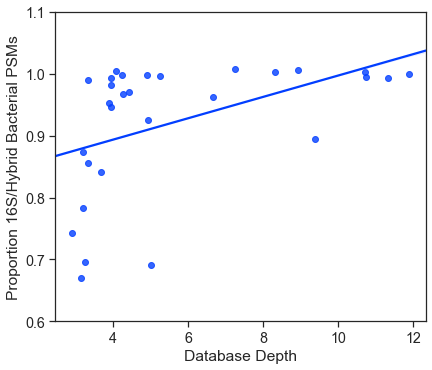

In [123]:
setPlt(size=(6, 5), ylim=(0.6, 1.1))
proportionVSDepthDF = pd.DataFrame({'Database Depth':sampleDepth, 'Proportion 16S/Hybrid Bacterial PSMs':TvsHProportion, 'BV':BV_STATUS})
depthGraph = sns.regplot(x='Database Depth', y='Proportion 16S/Hybrid Bacterial PSMs', data=proportionVSDepthDF, ci=1)
saveFig(depthGraph, figPath.joinpath('depth3_correlation.png'))

In [124]:
# Test whether there's a statistically significant association between tryptic peptide Sample Depth and Proportion of Tailored:Hybrid bacterial PSMs
stats.spearmanr(TvsHProportion, sampleDepth)

SpearmanrResult(correlation=0.6364532019704431, pvalue=0.00020600369062410105)

Getting really freaky with it now - I'm going to try to estimate panproteome coverage by making a curve to see how many new proteins are added (looking at amino acid sequence) by sequentially adding the next genome which adds the most new proteins.